In [1]:
%matplotlib widget
import numpy as np
from lienp.SE3 import SE3
from lienp.base import wedge3

import matplotlib.pyplot as plt

import ipywidgets as widgets

Text(0.5, 0, 'z')

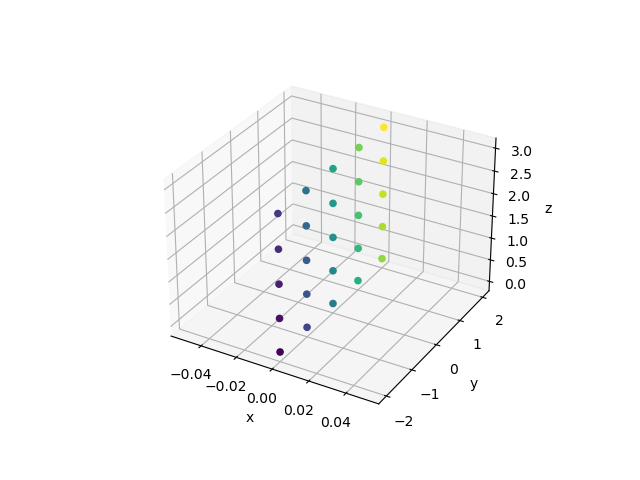

In [2]:
cube = np.array([
    [1, -1, -1,  1,  1, -1, -1,  1],
    [2,  2, -2, -2,  2,  2, -2, -2],
    [3,  3,  3,  3, -3, -3, -3, -3],
])
cube_h = np.vstack([cube, np.ones((8,))])

nx, ny, nz = (1, 5, 5)
x = np.linspace(0,1, nx)
y = np.linspace(-2,2, ny)
z = np.linspace(0, 3, nz)
grid = []
for i in range(nx):
    for j in range(ny):
        for k in range(nz):
            p = np.array([x[i], y[j], z[k]])
            grid.append(p)
grid = np.array(grid).T
grid_h = np.vstack([grid, np.ones(grid.shape[1])])

# grid_h = np.vstack([grid, np.ones()])

fig = plt.figure()
# ax1 = fig.add_subplot(121, projection='3d')
# ax1.plot(cube[0,:], cube[1,:], cube[2,:], 'o')
# ax1.set_aspect('equal')
# ax.voxels(np.ones([2, 4, 6]), edgecolors='k');
ax2 = fig.add_subplot(111,projection='3d')
ax2.scatter(grid[0,:], grid[1,:], grid[2,:], c=np.arange(grid.shape[1]), alpha=1)
# ax2.set_aspect('equal')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('z')

In [3]:
def dot_circ(p_h):
    """
    p_h is the homogeneous coordinate
    p_h = [epsilon eta]^T
    where epsilon is in R^3 and eta is the scalar factor
    """
    e = p_h[0:3]
    s = p_h[3]
    X = np.block([
        [s * np.eye(3), -wedge3(e)],
        [np.zeros(6)]
    ])
    return X

def circ_circ(p_h):
    e = p_h[0:3]
    s = p_h[3]
    X = np.block([
        [np.zeros((3,3)), e.reshape(3,1)],
        [-wedge3(e), np.zeros((3,1))]
    ])

    return X

In [4]:
K_ = np.array([[841.23917,   0.     , 773.0969],
           [0.     , 841.05691, 587.50195],
           [0.     ,   0.     ,   1.     ]])
f = 200
K_ = np.array([
    [f, 0, 320],
    [0, f, 240],
    [0, 0,   1]]).astype(np.float32)

R_model2cam = np.array([
    [0, 1, 0],
    [0, 0, 1],
    [1, 0, 0],        
])

# SE2, transform image coordiantes to match the book
SE2_pix2image = np.array([
    [-1, 0,  1600],
    [0, -1, 1200],
    [0, 0,  1],
])

SE2_pix2image = np.array([
    [-1, 0,  640],
    [0, -1, 480],
    [0, 0,  1],
])

K = SE2_pix2image @ K_ @ R_model2cam

K_t = np.block([
    [K, np.zeros((3,1))],
    ])
K_inv = np.linalg.inv(K)
print(K, K_inv)

[[ 320. -200.    0.]
 [ 240.    0. -200.]
 [   1.    0.    0.]] [[ 0.00000000e+00  0.00000000e+00  1.00000000e+00]
 [-5.00000000e-03  0.00000000e+00  1.60000000e+00]
 [-2.60208521e-19 -5.00000000e-03  1.20000000e+00]]


interactive(children=(FloatSlider(value=0.0, description='r', max=3.141592653589793, min=-3.141592653589793, s…

<function __main__.update(r=0, p=0, y=0)>

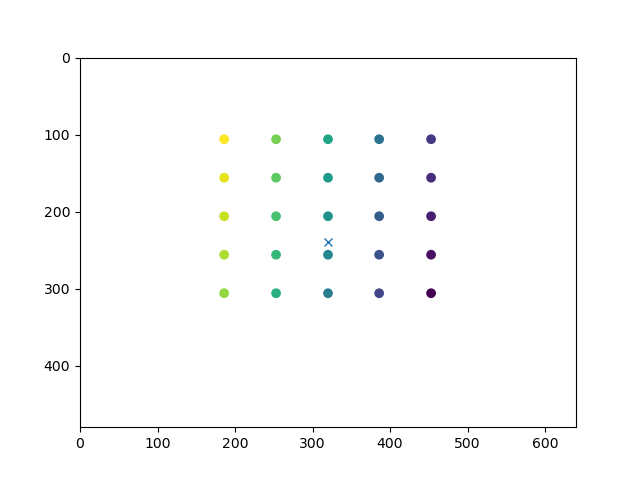

In [5]:
point_test = np.array([
    [2, 2],
    [0, 0],
    [2, -2],
]).astype(np.float32)
point_test_h = np.vstack([point_test, np.ones(2,)])
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)

# ax = plt.subplot(1,2,1)
ax1.set_ylim(480, 0)
ax1.set_xlim(0, 640)

# @widgets.interact(r=(-np.pi, np.pi, 0.01), p=(-np.pi/2, np.pi/2, 0.01), y=(-np.pi, np.pi, 0.01))
def update(r=0, p=0, y=0):
    pose_true = np.array([-3, 0, 1, r, p, y])

    T_true = SE3(param=pose_true)
    print(T_true.R)
    pix_h = K_t @ T_true.M @ grid_h
    scale = pix_h[-1, :] 
    pix = (pix_h / scale)[0:2,:].astype(int)
    print(pix)
    
    [l.remove() for l in ax1.lines]
    [c.remove() for c in ax1.collections]

    ax1.scatter(pix[0,:], pix[1,:], c=np.arange(pix.shape[1]))
    # ax1.plot(pix[0,:], pix[1,:])
    ax1.plot(320, 240, 'x')
    
widgets.interact(update, r=(-np.pi, np.pi, 0.01), p=(-np.pi/2, np.pi/2, 0.01), y=(-np.pi, np.pi, 0.01))

In [6]:
def get_V(K_inv, pix_h):
    """
    Projection matrix onto the pixel ray
    """
    bc = K_inv @ pix_h
    v = bc.reshape((3,1)) @ bc.reshape((1,3)) / (bc.T @ bc) # projection onto a line/ray 
    V = np.block([[v, np.zeros((3,1))],[np.zeros((1,3)), 1]]) # blocking the matrix to work with SE3 transformation matrix
    return V

def get_Vz_list(V_list, z):
    Vzdot_list = []
    Vz_list = []
    for Vi, zi in zip(V_list, z.T):
        Vz_i = (Vi - np.eye(4)) @ zi
        Vzdot_i = (Vi - np.eye(4)) @ dot_circ(zi)
        Vzdot_list.append(Vzdot_i)
        Vz_list.append(Vz_i)
    return Vz_list, Vzdot_list

def get_A(Vz_list, Vzdot_list):
    A = np.zeros((6,1))
    for Vz_i, Vzdot_i in zip(Vz_list, Vzdot_list):
        # print("==========")
        # print(Vi)
        # print(zi)
        A += (Vzdot_i.T @ Vz_i).reshape((6,1))
    return A

def get_B(Vzdot_list):
    B = np.zeros((6,6))
    for Vzdot_i in Vzdot_list:
        B += Vzdot_i.T @ Vzdot_i
    return B

In [7]:
pose_true = np.array([-5, 0, 1, -0.5, -0.2, 0.3])
T_true = SE3(param=pose_true)

pc = np.block([K, np.zeros((3,1))]) @ T_true.M @ grid_h
pc = (pc / pc[-1,:])
pc_int = pc.astype(int)

In [8]:
# %%timeit
# pc_noise = pc + np.vstack([np.random.normal(0, 1, (2,pc.shape[1])), np.zeros(pc.shape[1], int)])
pc_noise = pc + np.vstack([np.random.rayleigh(.1, (2,pc.shape[1])), np.zeros(pc.shape[1], int)])
V_list = [get_V(K_inv, p) for p in pc_noise.T]
# V_list = [get_V(K_inv, p) for p in pc.T]
# T_op = SE3(param=np.block([np.random.random((3,))*5, np.random.random((3,))*3]))
T_op = SE3(param=np.zeros(6))
for i in range(10):
    z = T_op @ grid_h
    Vz_list, Vzdot_list = get_Vz_list(V_list, z)
    A = get_A(Vz_list, Vzdot_list)
    B = get_B(Vzdot_list)
    ep = -np.linalg.inv(B) @ A
    # param = SE3.algebra_to_param(ep)
    T_op = SE3.exp(ep) @ T_op
    print(f"error: {np.squeeze(ep)}")
print(f"True: {pose_true}")
print(f"Estimated: {T_op.get_param()}")
print(f"Absolute error: {T_op.get_param()- pose_true}")


error: [ 5.58041241  1.13064517  0.12497727 -0.51096039 -0.28706968  0.15818298]
error: [-0.33161203 -0.87032805 -0.01762741  0.03157033  0.042827    0.07997846]
error: [-0.00123956 -0.00737845 -0.01215247 -0.00027323 -0.00028412  0.0008038 ]
error: [-4.99522160e-06  3.22187970e-06  1.39847822e-05 -6.11013432e-07
  2.66165111e-06 -8.68388603e-07]
error: [ 1.74291783e-08 -3.15067010e-08 -1.58826172e-08 -4.97617965e-10
 -3.67532980e-09  6.46998297e-09]
error: [-5.29711444e-11  4.83049400e-11  1.00976346e-10 -3.75868115e-12
  2.02864552e-11 -1.16520558e-11]
error: [ 1.60554686e-13 -2.45482209e-13 -1.95490390e-13  4.01105338e-16
 -4.23394587e-14  5.20427685e-14]
error: [ 1.90748305e-15  4.76577555e-16  1.56371604e-15 -6.27846519e-17
  2.66909586e-16 -1.42155055e-16]
error: [ 4.08681047e-15 -2.44319767e-16  1.82146863e-16 -1.73303583e-18
 -3.71625980e-17  9.87964266e-17]
error: [ 2.59024425e-15 -2.83182697e-16  1.63344501e-16 -1.63135533e-17
 -7.14626041e-17  2.89009746e-17]
True: [-5.   0.

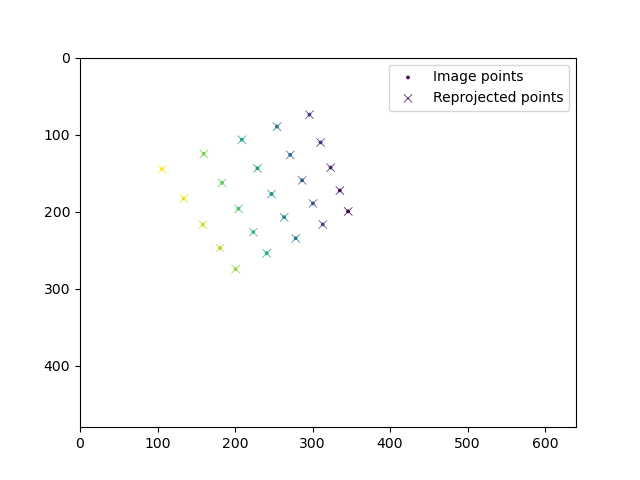

In [9]:
pc_proj = np.block([K, np.zeros((3,1))]) @ T_op.M @ grid_h
pc_proj =(pc_proj / pc_proj[-1,:])
fig = plt.figure()
plt.scatter(pc[0,:], pc[1,:], c=np.arange(pc.shape[1]), s=3, label='Image points')
plt.scatter(pc_proj[0,:], pc_proj[1,:], c=np.arange(pc_proj.shape[1]), marker='x', linewidths=.5, label='Reprojected points')
plt.xlim((0,640))
plt.ylim((480,0))
plt.legend()

In [10]:
import cv2
from lienp.SO3 import SO3
from skspatial.objects import Line, LineSegment, Plane, Points
print(pc_noise.shape)
_, rvec, tvec = cv2.solvePnP(grid.T, pc_noise[0:2,:].T, K_, np.array([]), flags=cv2.SOLVEPNP_SQPNP)

rvec, tvec = cv2.solvePnPRefineVVS(grid.T, pc_noise[0:2,:].T, K_, np.array([]), rvec, tvec)
rvec, tvec
SO3.exp(rvec)

(3, 25)


array([[-0.28965622, -0.86648827, -0.40656778],
       [-0.19872551,  0.46996585, -0.86002342],
       [ 0.93627317, -0.16831574, -0.30832185]])

Line(point=Point([0., 0., 0.]), direction=Vector([1., 0., 0.]))
Line(point=Point([-4.99821069e+00,  2.53805941e-05,  1.00132893e+00]), direction=Vector([ 0.93647808, -0.16807761, -0.30782905]))


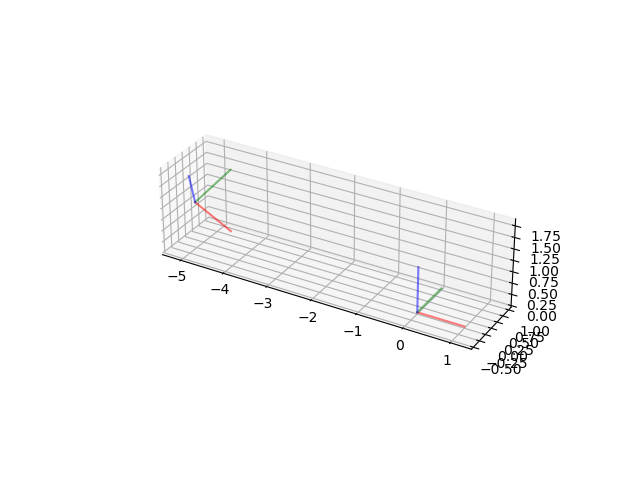

In [11]:
def draw_ref_frame(ax, T, scale=1, alpha=.5):
    c = T.c
    R = T.R
    l1 = Line(c, R[0,:])
    l2 = Line(c, R[1,:])
    l3 = Line(c, R[2,:])
    print(l1)
    ax1 = LineSegment(c, l1.to_point(scale))
    ax2 = LineSegment(c, l2.to_point(scale))
    ax3 = LineSegment(c, l3.to_point(scale))
    ax1.plot_3d(ax, color='r', alpha=alpha)
    ax2.plot_3d(ax, color='g', alpha=alpha)
    ax3.plot_3d(ax, color='b', alpha=alpha)

def transform_cvframe(rvec, tvec):
    R_cam = SO3.exp(rvec)
    R_cv = np.array([
        [ 0,  0,  1],
        [-1,  0,  0],
        [ 0, -1,  0]
    ])
    return SE3(R= R_cv @ R_cam, c=-R_cam.T @ tvec)

R_cv = np.array([
    [ 0,  0,  1],
    [-1,  0,  0],
    [ 0, -1,  0]
])

fig_ = plt.figure()
ax = fig_.add_subplot(111, projection='3d')

draw_ref_frame(ax, SE3(np.zeros(6)))
draw_ref_frame(ax, SE3(R=T_op.R, c=T_op.c))
# draw_ref_frame(ax, T_op)
# draw_ref_frame(ax, SE3(R=R_cv, c=np.zeros(3)), scale=0.5, alpha=1)

T_cam_cv = transform_cvframe(rvec, tvec)
# draw_ref_frame(ax, T_cam_cv)
# draw_ref_frame(ax, T_cam_cv.inv)


ax.set_aspect('equal')

In [12]:
target_size = np.array([0.4, 0.4, 0.25])
vtx = (-1,1)
target_3dbox = []
for ix in vtx:
    for iy in vtx:
        for iz in vtx:

            target_3dbox.append(np.array([ix, iy, iz]) * target_size/2)
target_3dbox = np.array(target_3dbox)
print(target_3dbox)

box_tranformed = T_op.inv @ np.hstack([target_3dbox, np.ones((8,1))]).T
Points(box_tranformed.T[:, 0:-1]).plot_3d(ax)
ax.set_aspect('equal')

[[-0.2   -0.2   -0.125]
 [-0.2   -0.2    0.125]
 [-0.2    0.2   -0.125]
 [-0.2    0.2    0.125]
 [ 0.2   -0.2   -0.125]
 [ 0.2   -0.2    0.125]
 [ 0.2    0.2   -0.125]
 [ 0.2    0.2    0.125]]


In [16]:
R_corr = SO3.from_euler(np.array([np.pi, 0, 0]))
q_corr = SO3.euler_to_quat(np.array([np.pi,0,0]))

SO3.from_quat(q_corr)

def quat_product(qa, qb):
    r1 = qa[0]
    v1 = qa[1:]
    r2 = qb[0]
    v2 = qb[1:]
    res = np.zeros((4,))
    res[0] = r1 * r2 - np.dot(v1, v2)
    res[1:] = r1 * v2 + r2 * v1 + np.cross(v1, v2)
    return res

q1 = np.array([1,0,0,0])


array([[ 1.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00, -1.0000000e+00, -1.2246468e-16],
       [ 0.0000000e+00,  1.2246468e-16, -1.0000000e+00]])